In [1]:
import os as os
import warnings

import cudaq
import matplotlib.pyplot as plt
import pandas as pd
from bigdatavqa.ansatz import get_QAOA_circuit, get_VQE_circuit
from bigdatavqa.coreset import BFL2, D2_sampling
from bigdatavqa.Hamiltonians import get_GMM_Hamiltonian
from bigdatavqa.gmm import (
    GMMClusteringClassicalGMM,
    GMMClusteringMaxCut,
    GMMClusteringRandom,
    GMMClusteringVQA,
)
from bigdatavqa.optimizer import get_optimizer_for_QAOA, get_optimizer_for_VQE

warnings.filterwarnings("ignore")

In [2]:
qubits = 10
coreset_size = qubits
circuit_depth = 1
max_shots = 1000
max_iterations = 100
number_of_experiment_runs = 5
number_of_corsets_to_evaluate = 15
number_of_centroid_evaluation = 20

## Data

In [3]:
raw_data = BFL2.create_dataset(1000)

coreset = BFL2(
    raw_data=raw_data,
    number_of_sampling_for_centroids=10,
    coreset_size=coreset_size,
    number_of_coresets_to_evaluate=4,
    sampling_method=D2_sampling,
)


coreset_vectors, coreset_weights = coreset.get_best_coresets()

vector_columns = ["X", "Y"]
weights_column = "weights"

coreset_df = pd.DataFrame(coreset_vectors, columns=list("XY"))
coreset_df[weights_column] = coreset_weights
coreset_df["Name"] = [chr(i + 65) for i in coreset_df.index]
coreset_df

,X,Y,weights,Name
0,1.658088,-1.257017,63.917870,A
1,0.481738,1.078941,35.983742,B
2,-0.448921,0.572372,78.382790,C
3,-0.393163,1.952372,60.118733,D
4,5.722463,1.400433,76.501192,E
5,5.597369,1.166489,52.001588,F
6,7.873476,-0.036354,82.330736,G
7,0.739147,-1.243852,105.996911,H
8,-0.826549,0.400589,73.072590,I
9,7.857116,-0.336100,96.746904,J


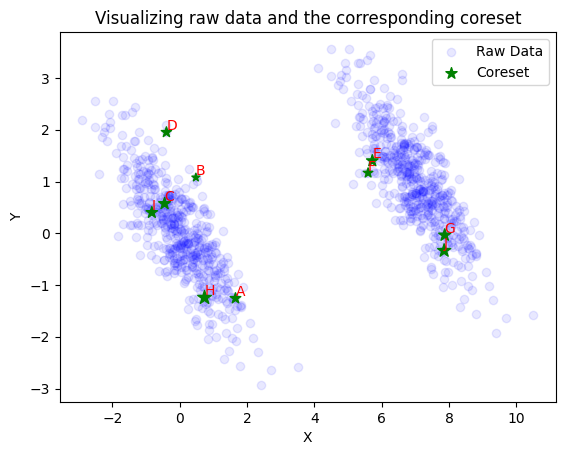

In [4]:
plt.scatter(raw_data[:, 0], raw_data[:, 1], color="blue", alpha=0.09, label="Raw Data")
plt.scatter(
    coreset_df.X,
    coreset_df.Y,
    s=coreset_df.weights,
    marker="*",
    color="green",
    label="Coreset",
)
for idx, row in coreset_df.iterrows():
    plt.annotate(row["Name"], xy=(row.X, row.Y + 0.05), color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Visualizing raw data and the corresponding coreset")
plt.show()

## VQE

In [5]:
optimizer = cudaq.optimizers.COBYLA()

VQE_GMM = GMMClusteringVQA(
    full_coreset_df = coreset_df,
    vector_columns=vector_columns,
    weights_column=weights_column,
    qubits=qubits,
    create_circuit=get_VQE_circuit,
    circuit_depth=1,
    optimizer_function=get_optimizer_for_VQE,
    optimizer=optimizer,
    create_Hamiltonian=get_GMM_Hamiltonian,
    normalize_vectors=True,
    max_iterations=max_iterations,
    max_shots=max_shots,
)

VQE_GMM.fit()

VQE_cost = VQE_GMM.cost

print(f"VQE cost: {VQE_cost}")



VQE cost: 58.28164976614343


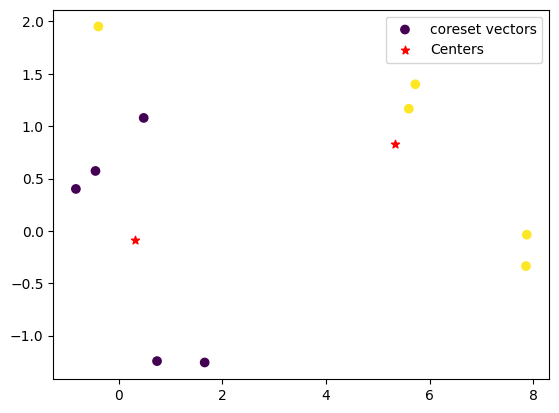

In [6]:
VQE_GMM.plot()

## Clustering using QAOA bitstring

In [7]:
optimizer = cudaq.optimizers.COBYLA()

QAOA_GMM = GMMClusteringVQA(
    full_coreset_df = coreset_df,
    vector_columns=vector_columns,
    weights_column=weights_column,
    qubits=qubits,
    create_circuit=get_QAOA_circuit,
    circuit_depth=1,
    optimizer_function=get_optimizer_for_QAOA,
    optimizer=optimizer,
    create_Hamiltonian=get_GMM_Hamiltonian,
    normalize_vectors=True,
    max_iterations=max_iterations,
    max_shots=max_shots,
)

QAOA_GMM.fit()

QAOA_cost = QAOA_GMM.cost

print(f"QAOA cost: {QAOA_cost}")

QAOA cost: 119.92180840884494


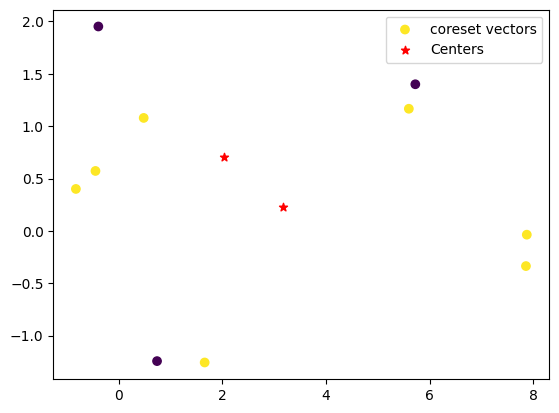

In [8]:
QAOA_GMM.plot()

## Clustering using GMM bitstring

In [9]:
classical_GMM = GMMClusteringClassicalGMM(coreset_df, vector_columns, weights_column, normalize_vectors = True)

classical_GMM.fit()

classical_cost = classical_GMM.cost

print(f"classical cost: {classical_cost}")

classical cost: 19.641235854731317


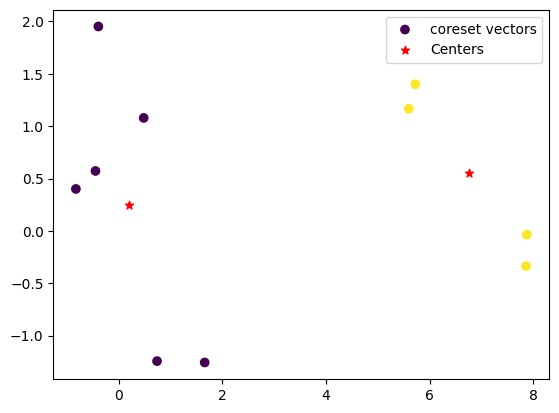

In [10]:
classical_GMM.plot()

## Clustering using Random

In [11]:
random_GMM = GMMClusteringRandom(coreset_df, vector_columns, weights_column)
random_GMM.fit()

random_cost = random_GMM.cost

print(f"random cost: {random_cost}")

random cost: 122.89121718692269


## Clustering using MaxCut

In [13]:
maxcut_GMM = GMMClusteringMaxCut(coreset_df, vector_columns, weights_column, normalize_vectors = True)

maxcut_GMM.fit()

maxcut_cost = maxcut_GMM.cost

print(f"MaxCut cost: {maxcut_cost}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1022/1022 [00:02<00:00, 425.45it/s]

MaxCut cost: 19.641235854731317


In [14]:
cost_values = [random_cost, VQE_cost, QAOA_cost, classical_cost, maxcut_cost]


labels = ["Random Cluster", "VQE", "QAOA", "Classical GMM", "MaxCut"]


plt.bar(labels, cost_values)


plt.xlabel("Method")
plt.ylabel("Cost Value")
plt.title("Cost Values Comparison (Lower is better)")


plt.show()

NameError: name 'GMM_random' is not defined